# MinuteWeather Data Clustering using K-Means

### Minute Weather Data Description
The minute weather dataset comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file minute_weather.csv, which is a comma-separated file.


### Each row in minute_weather.csv contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

rowID: unique number for each row (Unit: NA)

hpwren_timestamp: timestamp of measure (Unit: year-month-day hour:minute:second)

air_pressure: air pressure measured at the timestamp (Unit: hectopascals)

air_temp: air temperature measure at the timestamp (Unit: degrees Fahrenheit)

avg_wind_direction: wind direction averaged over the minute before the timestamp (Unit: degrees, with 0 means coming from the North, and increasing clockwise)

avg_wind_speed: wind speed averaged over the minute before the timestamp (Unit: meters per second)

max_wind_direction: highest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and increasing clockwise)

max_wind_speed: highest wind speed in the minute before the timestamp (Unit: meters per second)

min_wind_direction: smallest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and inceasing clockwise)

min_wind_speed: smallest wind speed in the minute before the timestamp (Unit: meters per second)

rain_accumulation: amount of accumulated rain measured at the timestamp (Unit: millimeters)

relative_humidity: relative humidity measured at the timestamp (Unit: percent)

### Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

### Reading the csv file

In [4]:
data = pd.read_csv('D:\\Internships\\TCR Innovation\\Assignments\\minute_weather.csv\\minute_weather.csv')

In [5]:
data.shape

(1587257, 13)

In [6]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


### Lots of rows, so let us sample down by taking every 10th row.

In [7]:
df = data[(data['rowID'] % 10) == 0]
df.shape

(158726, 13)

### This reduced the numbers of rows from 1,587,257 down to 158,726, with the columns remaining the same at thirteen.

it is important to analyze the data and determine if there are any null values. 
 
 If there are null values found, we can remove those items. 
 
 In this sample data set, it is found that “rain_accumulation” and “rain_duration” contain null values. 

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [13]:
df[df['rain_accumulation'] == 0].shape

(157812, 13)

In [14]:
df[df['rain_duration'] == 0].shape

(157237, 13)

#### Drop all the Rows with Empty rain_duration and rain_accumulation

In [15]:
del df['rain_accumulation']
del df['rain_duration']

In [17]:
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]

In [18]:
rows_before - rows_after

0

In [19]:
df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

#### will be the process of identifying the columns of interest for clustering and then sorting them into a data frame.

In [20]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [22]:
select_df =df[features]

In [23]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [24]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
...,...,...,...,...,...,...,...
1587210,915.9,75.56,330.0,1.0,341.0,1.3,47.8
1587220,915.9,75.56,330.0,1.1,341.0,1.4,48.0
1587230,915.9,75.56,344.0,1.4,352.0,1.7,48.0
1587240,915.9,75.20,359.0,1.3,9.0,1.6,46.3


#### Scale the Features using StandardScaler

In [25]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

### K-Means Clustering

In [26]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=12)


In [29]:
model
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=1)

KMeans(n_clusters=12, n_jobs=None, precompute_distances='auto', verbose=1)

### What are the centers of 12 clusters we formed ?

In [30]:
centers = model.cluster_centers_
centers

array([[ 0.13285865,  0.84072423,  1.41119776, -0.63881568,  1.6753334 ,
        -0.58972862, -0.71258049],
       [-0.15958222,  0.86226619, -1.31116175, -0.58971789, -1.16682105,
        -0.60502767, -0.64355508],
       [-0.84033182, -1.20299331,  0.37705975,  0.39334081,  0.4751124 ,
         0.38079415,  1.36024364],
       [ 1.18949012, -0.25497958, -1.15500583,  2.12670827, -1.05349792,
         2.24383423, -1.13476291],
       [ 0.72471336,  0.43585976,  0.28552284, -0.53606206,  0.47317284,
        -0.54225898, -0.76553329],
       [ 1.37129639, -0.08419901, -1.20646242, -0.04459066, -1.07551806,
        -0.02409855, -0.9779026 ],
       [ 0.23424622,  0.32158231,  1.88796727, -0.65172676, -1.55185459,
        -0.57666164, -0.2845489 ],
       [-0.2093392 ,  0.63627474,  0.40869464,  0.73217001,  0.51696175,
         0.6706394 , -0.1530126 ],
       [ 0.05993398, -0.78761132, -1.19720398, -0.57075061, -1.04335794,
        -0.58535746,  0.8779712 ],
       [-1.18344984, -0.8632

### Plotting Graphs

In [31]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [33]:
# Function that creates Parallel Plots

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [34]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.132859,0.840724,1.411198,-0.638816,1.675333,-0.589729,-0.712580,0
1,-0.159582,0.862266,-1.311162,-0.589718,-1.166821,-0.605028,-0.643555,1
2,-0.840332,-1.202993,0.377060,0.393341,0.475112,0.380794,1.360244,2
3,1.189490,-0.254980,-1.155006,2.126708,-1.053498,2.243834,-1.134763,3
4,0.724713,0.435860,0.285523,-0.536062,0.473173,-0.542259,-0.765533,4
5,1.371296,-0.084199,-1.206462,-0.044591,-1.075518,-0.024099,-0.977903,5
6,0.234246,0.321582,1.887967,-0.651727,-1.551855,-0.576662,-0.284549,6
7,-0.209339,0.636275,0.408695,0.732170,0.516962,0.670639,-0.153013,7
8,0.059934,-0.787611,-1.197204,-0.570751,-1.043358,-0.585357,0.877971,8
9,-1.183450,-0.863254,0.446874,1.991680,0.537802,1.952137,0.901589,9


### Warm Days

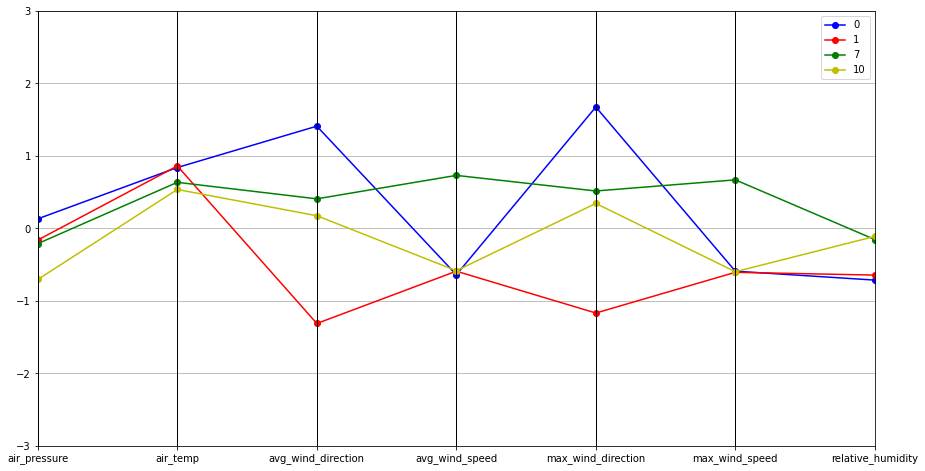

In [35]:
parallel_plot(P[P['air_temp'] > 0.5])

### Cool Days

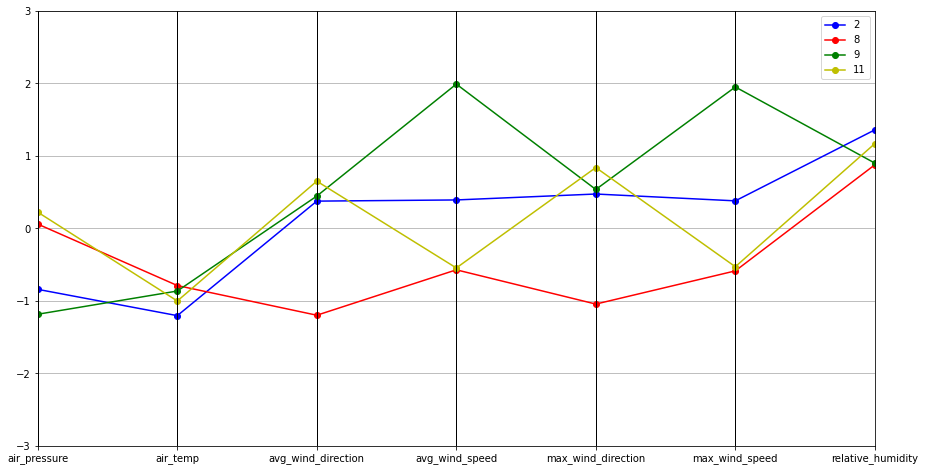

In [36]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])

### Dry Days

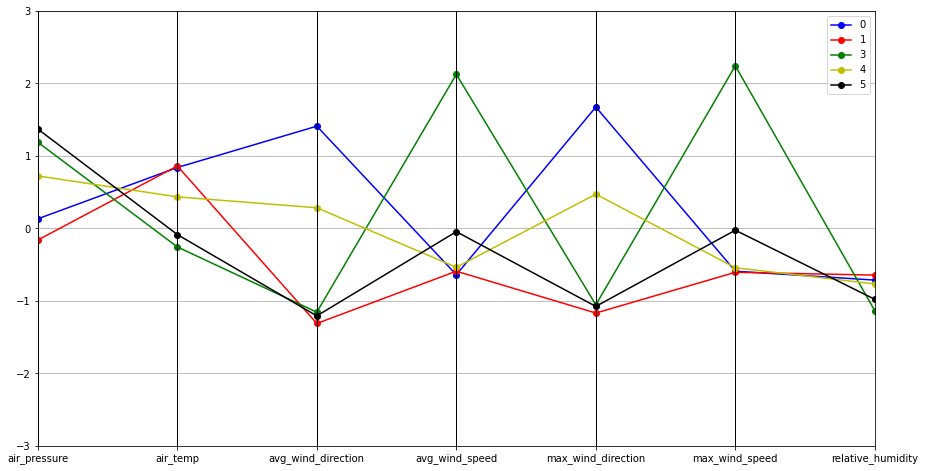

In [37]:
parallel_plot(P[P['relative_humidity'] < -0.5])